# Assingnment 4

Niko Fauter (1047241)

Henning Klatt (1079429)

### Directional Differenz Calculation

In [31]:
using Images, Plots, FileIO, ImageIO
function getOrientationChannels(img) 
        imgArray = channelview(float.(img))
        g_0=zeros(size(imgArray))
        g_45=zeros(size(imgArray))
        g_90=zeros(size(imgArray))     
        g_135=zeros(size(imgArray))            
        for i in eachindex(view(imgArray,1:size(imgArray,1),1:size(imgArray,2)))
            if i[2] == size(imgArray,2)
                g_0[i]=0
                g_45[i]=0
                if i[1] == size(imgArray,1)
                    g_90[i]=0   
                else
                    g_90[i]=imgArray[i]-imgArray[i[1]+1,i[2]]                          
                end
                
            else
                g_0[i]=imgArray[i]-imgArray[i[1],i[2]+1]
                if i[1]== size(imgArray,1)
                    g_45[i]=0
                else
                    
                    g_45[i]=imgArray[i]-imgArray[i[1]+1,i[2]+1]
                    g_90[i]=imgArray[i]-imgArray[i[1]+1,i[2]] 
                end
            end
            if i[2] == 1 || i[1]==size(imgArray,1)
                g_135[i]=0
            else
                g_135[i]=imgArray[i]-imgArray[i[1]+1,i[2]-1]
            end
        end   
        return g_0.^2,g_45.^2,g_90.^2,g_135.^2
end
function maxmin(c_0,c_45,c_90,c_135,max)
    c_maxmin=zeros(size(c_0))
    for i in eachindex(c_0)
        if max
            c_maxmin[i]=maximum([c_0[i], c_45[i], c_90[i], c_135[i]])
        else
            c_maxmin[i]=minimum([c_0[i], c_45[i], c_90[i], c_135[i]])
        end
    end
    return c_maxmin
end


function normalize(c_0,c_45,c_90,c_135,avg)
    if avg
        sum=c_0 .+ c_45 .+ c_90 + c_135
        c_0_avg= c_0./sum
        c_45_avg=c_45./sum
        c_90_avg=c_90./sum
        c_135_avg=c_135./sum
        return c_0_avg,c_45_avg,c_90_avg, c_135_avg
    else
        max=maxmin(c_0,c_45,c_90,c_135,true)
        c_0_max= c_0./max
        c_45_max=c_45./max
        c_90_max=c_90./max
        c_135_max=c_135./max
        return c_0_max,c_45_max,c_90_max, c_135_max
    end
end
function moravec(img, avg_normed, threshold)
g_0,g_45,g_90,g_135 =getOrientationChannels(shapes);

box=centered(ones(5,5))
c_0= imfilter(g_0,box)
c_45=imfilter(g_45,box)
c_90=imfilter(g_90,box)
c_135=imfilter(g_135,box);

c_0_norm,c_45_norm,c_90_norm, c_135_norm=normalize(c_0,c_45,c_90,c_135,avg_normed)

c_min=maxmin(c_0_avg,c_45_avg,c_90_avg, c_135_avg,false)
#thresholding
c_result=c_min.>threshold
    return c_result
end


moravec (generic function with 1 method)

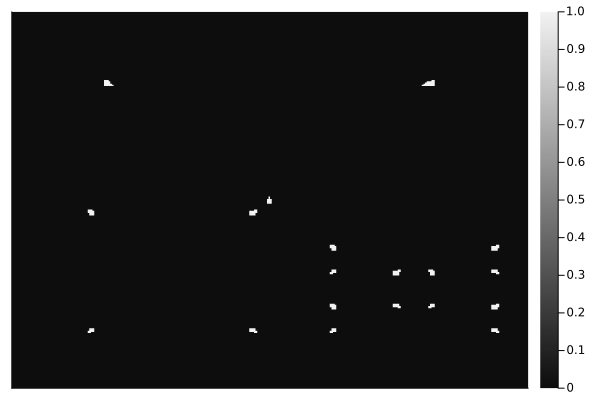

In [32]:
shapes=load("shapes1.png")
c_result=moravec(shapes,true,0.1)
heatmap(c_result,color=:grays,xticks=false,yticks=false)

### 

In [33]:
function roc(img, keypointMap,threshold)
    FPR=0
    TPR=0
    n_kp=0
    n_nkp=0
    n=0
    c_result=moravec(img,true,threshold)
    for i in eachindex(img)

        if keypointMap[i] 
            n_kp+=1
            if c_result[i]
                TPR+=1
            end
        else
            n_nkp+=1
            if c_result[i]
                FPR+=1
            end
        end
        n=n+1
    end
    if (n_kp+n_nkp==n)
        return FPR/n_nkp, TPR/n_kp
    end
end
        

roc (generic function with 1 method)

In [34]:
keypoints = load("keypoints.png")
keypoints=channelview(float.(keypoints))
#transformation to boolean
keypoints=(keypoints .>0.5)
shapes=load("shapes1.png")
FPR,TPR =roc(shapes,keypoints,0.01)

(0.0005389884656468351, 0.9803921568627451)

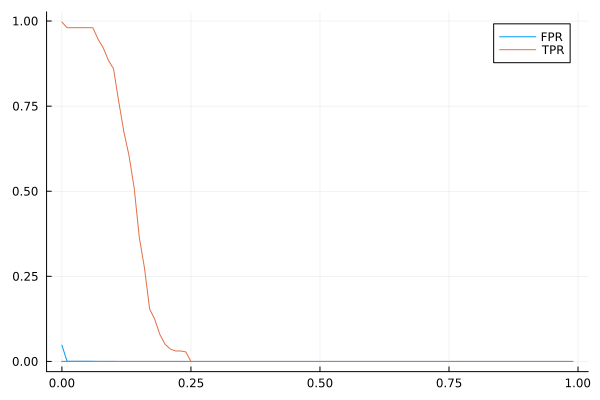

In [39]:
function evaluateROC(img,keypointMap)
    threshold=0
    FPR_vec=zeros(101)
    TPR_vec=zeros(101)
    threshold_vec=zeros(101)
    i=1
    while threshold <=1
        FPR,TPR =roc(img,keypoints,threshold)
        FPR_vec[i]=FPR
        TPR_vec[i]=TPR
        threshold_vec[i]=threshold
        threshold +=0.01
        i+=1
    end
    plot(threshold_vec,[FPR_vec,TPR_vec],label=["FPR" "TPR"])
end       
keypoints = load("keypoints.png")
keypoints=channelview(float.(keypoints))
#transformation to boolean
keypoints=(keypoints .>0.5)
shapes=load("shapes1_noisy.png")
evaluateROC(shapes,keypoints)     